# AI Mapping
提取照片的主题色并将其用于地图上色。  
Idea源自微信公众号易智瑞中国的文章《当地图遇上AI：会碰撞出什么样的火花？》
### 原理
1. 针对某幅图像我们定义K个类别，利用K-means聚类算法将图像中的像素值进行聚类
2. 提取每类的色彩值并按照色彩所含像素数目进行排序
3. 然后按照图层面积大小或长度将排序后的色彩匹配至图层中

In [53]:
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from skimage import io,transform
import numpy as np

### 原图展示

In [54]:
# img_file = io.imread('images/yourname.jpeg') # 你的名字
# img_file = io.imread('images/PeggaPig.jpeg') # 小猪佩奇
# img_file = io.imread('images/happysheep.jpeg') # 喜羊羊与灰太狼
# img_file = io.imread('images/totoro.jpeg') # 龙猫
# img_file = io.imread('images/frozen.jpeg') # 冰雪奇缘
# img_file = io.imread('images/shuimo.jpeg') # 水墨
img_file = io.imread('images/RickMorty.jpeg') # 瑞克与莫迪
# img_file = io.imread('images/shnu.jpeg') # 上师大
# img_file = io.imread('images/conan.jpeg') # 柯南
height = img_file.shape[0]
width = img_file.shape[1]
print(img_file.shape)
print(img_file.size)

(1125, 1356, 3)
4576500


In [55]:
img_file.reshape(-1, 3)

Array([[37, 30, 37],
       [37, 30, 37],
       [37, 30, 37],
       ...,
       [66, 88, 75],
       [66, 88, 75],
       [66, 88, 75]], dtype=uint8)

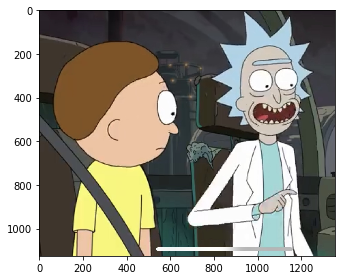

In [56]:
io.imshow(img_file)

### KMeans算法提取主题色

In [57]:
# meanShift = MeanShift()
# cluster = meanShift.fit(img_file.reshape(-1, 3))

In [58]:
# nclusters = len(cluster.cluster_centers_)

method1: 自行设定聚类簇的个数

In [59]:
nclusters=12 # 设定聚类簇的个数
kmeans = KMeans(
    n_clusters = nclusters,
#     random_state=0
)
cluster = kmeans.fit(img_file.reshape(-1, 3))

method2: 通过轮廓系数自动得出最佳聚类簇个数(很慢)

In [60]:
# scores = []  # 存放轮廓系数
# for k in range(4, 13, 2):
#     data = img_file.reshape(-1, 3)
#     kmeans = KMeans(
#         n_clusters = k,
#         random_state = 0
#     )
#     cluster = kmeans.fit(data)
#     score = silhouette_score(data, cluster.labels_, metric='euclidean')
#     scores.append(score)
#     print(score)

In [61]:
# 将结果转换为[height, width, 3]的矩阵
result = kmeans.labels_.reshape(height, width, 1)
result_ = np.tile(result, (1, 1, 3))

In [62]:
count = np.array([len(kmeans.labels_[kmeans.labels_==i]) for i in range(0, nclusters)])
print('各聚类簇所含的像元个数：')
print(count)

各聚类簇所含的像元个数：
[ 69564 327461  53098 118719 128692 143554  93430  96003  92012 221617
  28367 152983]


In [63]:
# 生成频率排序
# 解读方法：排第1的是0，第2的是3...即排好序的数字原本的位置是哪里
sort = np.argsort(-count) # 按照sort里的索引排序出来的是逆序
print(sort)
sort_dict = {}
i = 0
for s in sort:
    sort_dict[i] = sort[i]
    i += 1
sort_dict = {value:key for key,value in sort_dict.items()}
print(sort_dict)

[ 1  9 11  5  4  3  7  6  8  0  2 10]
{1: 0, 9: 1, 11: 2, 5: 3, 4: 4, 3: 5, 7: 6, 6: 7, 8: 8, 0: 9, 2: 10, 10: 11}


### 提取平均色并按照频率排序

In [64]:
sort_l = [[0, 0, 0]]*nclusters
l = []
for i in range(0, nclusters):
    r = img_file[result_ == i].reshape(-1, 3)[:, 0].mean()
    g = img_file[result_ == i].reshape(-1, 3)[:, 1].mean()
    b = img_file[result_ == i].reshape(-1, 3)[:, 2].mean()
    print(r, g, b)
    l.append([round(r), round(g), round(b)])
    sort_l[sort_dict[i]] = [round(r), round(g), round(b)]
    print(sort_dict[i])

207.1594790408832 199.95188603300556 193.37697659709045
9
54.29937305511191 49.67918927750175 45.39371100680692
0
110.8170175901164 114.45636370484765 109.68972466006252
10
235.72210008507483 196.15880356135077 164.19285876734136
5
123.67791315699499 83.92673981288658 41.48394616603985
4
251.53707315713947 251.3007161068309 251.2648062749906
3
175.07608905062614 210.845499304292 220.338499411324
7
76.91429434496838 81.80284991094028 79.4511109027843
6
247.35022605747076 245.42792244489848 129.84434638960136
8
55.83925420883777 62.13516562357581 63.4888614140612
1
158.34755173264708 157.49730320442768 147.89734550710332
11
33.422334507755764 33.23820947425531 32.94671957014832
2


In [65]:
# np.tile(sort_l, (1, 1, 1)) + np.zeros([10, 8, 3])
# sort_l_img = np.tile(sort_l, (1, 1, 1))
# sort_l_img

In [66]:
z = np.zeros([100, nclusters*100, 3])
for i in range(0, nclusters):
    for j in range(0, 3):
        z[0:100, i*100:(i+1)*100, j] = sort_l[i][j]

In [67]:
sort_l

[[54.0, 50.0, 45.0],
 [56.0, 62.0, 63.0],
 [33.0, 33.0, 33.0],
 [252.0, 251.0, 251.0],
 [124.0, 84.0, 41.0],
 [236.0, 196.0, 164.0],
 [77.0, 82.0, 79.0],
 [175.0, 211.0, 220.0],
 [247.0, 245.0, 130.0],
 [207.0, 200.0, 193.0],
 [111.0, 114.0, 110.0],
 [158.0, 157.0, 148.0]]

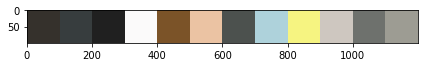

In [68]:
io.imshow(z/256)

### 使用聚类的颜色制图

In [69]:
for i in range(0, nclusters):
    for j in range(0, 3):
        result_[:, :, j][result_[:, :, j] == i] = l[i][j]

/Users/yych97/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


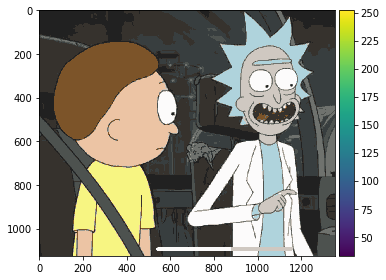

In [70]:
io.imshow(result_)

### 地图制图

In [71]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import mapclassify as mc

In [72]:
# mc.User_Defined?

In [73]:
# load the data
# nyc_boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
# tickets = gpd.read_file(gplt.datasets.get_path('nyc_parking_tickets'))
songjiang = gpd.read_file('/Users/yych97/data/shapefile/songjiang_subset')
songjiang = songjiang.dropna()
print(songjiang.crs)

{'init': 'epsg:4326'}


In [74]:
# 按面积排序
gb = songjiang.groupby('LAND_USE_T').sum().sort_values('AREA', ascending=False)
songjiang['sort'] = 0
for i in range(0, 12):
#     print(i)
    songjiang.loc[songjiang[songjiang['LAND_USE_T'] == gb.index[i]].index, 'sort'] = i

In [75]:
colors = np.array(sort_l)/256
print(colors)
# colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
# n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'my_list'

[[0.2109375  0.1953125  0.17578125]
 [0.21875    0.2421875  0.24609375]
 [0.12890625 0.12890625 0.12890625]
 [0.984375   0.98046875 0.98046875]
 [0.484375   0.328125   0.16015625]
 [0.921875   0.765625   0.640625  ]
 [0.30078125 0.3203125  0.30859375]
 [0.68359375 0.82421875 0.859375  ]
 [0.96484375 0.95703125 0.5078125 ]
 [0.80859375 0.78125    0.75390625]
 [0.43359375 0.4453125  0.4296875 ]
 [0.6171875  0.61328125 0.578125  ]]


In [76]:
# 生成matplotlib自定义colormap
cm = LinearSegmentedColormap.from_list(cmap_name, colors[0:nclusters], N=nclusters) # 通过colors[0:N]可以选择提取前N类

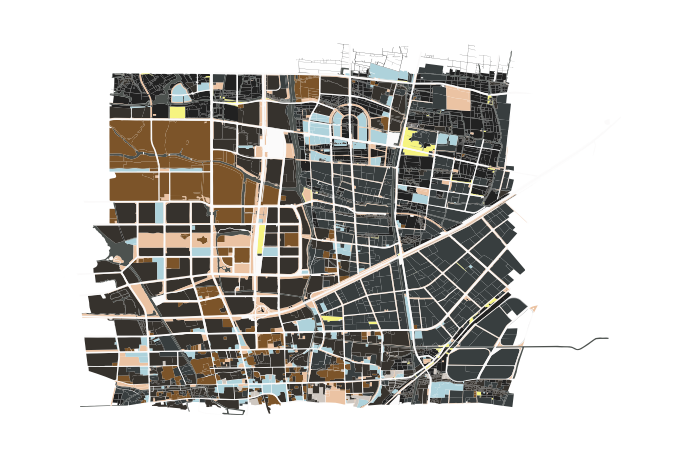

In [77]:
# gplt.choropleth(
#     tickets.set_index('id').loc[:, ['ny', 'geometry']],
#     hue='ny', cmap=cm,
#     linewidth=0.0
# )
# scheme = mc.Equal_Interval(range(12), 6)
gplt.choropleth(
    songjiang,
    hue='sort', cmap=cm,
#     sheme=scheme,
    linewidth=0.0,
    figsize=(12, 12),
#     legend=True
)

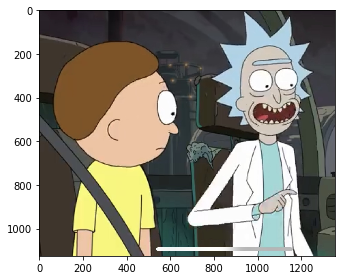

In [78]:
io.imshow(img_file)

### References
[1] Color Quantization using K-Means[EB/OL].https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html  
[2] 图像主题色提取算法[EB/OL].https://blog.csdn.net/shanglianlm/article/details/50051269  
[3] 当地图遇上AI：会碰撞出什么样的火花？[EB/OL].https://mp.weixin.qq.com/s/thBLKuzQQaqPWMLVpdAerA  
[4] K-means聚类最优k值的选取[EB/OL].https://blog.csdn.net/qq_15738501/article/details/79036255  
[5] 朱培恺,刘敬浩.基于改进K-means的图片主色提取方法[J].南开大学学报(自然科学版),2019,52(06):12-18.  
[6] 杨慧炯.面向自然图像的自适应主色提取方法研究[J].微电子学与计算机,2018,35(09):99-102+107.  
[7] 朱臻阳,刘春晓,伍敏,陈丽丽.主色提取的直方图峰值筛选与剔除方法[J].中国图象图形学报,2015,20(09):1151-1160.  